#**Project: Enhancing Restaurant Driv-thru Order Processing with RAG**

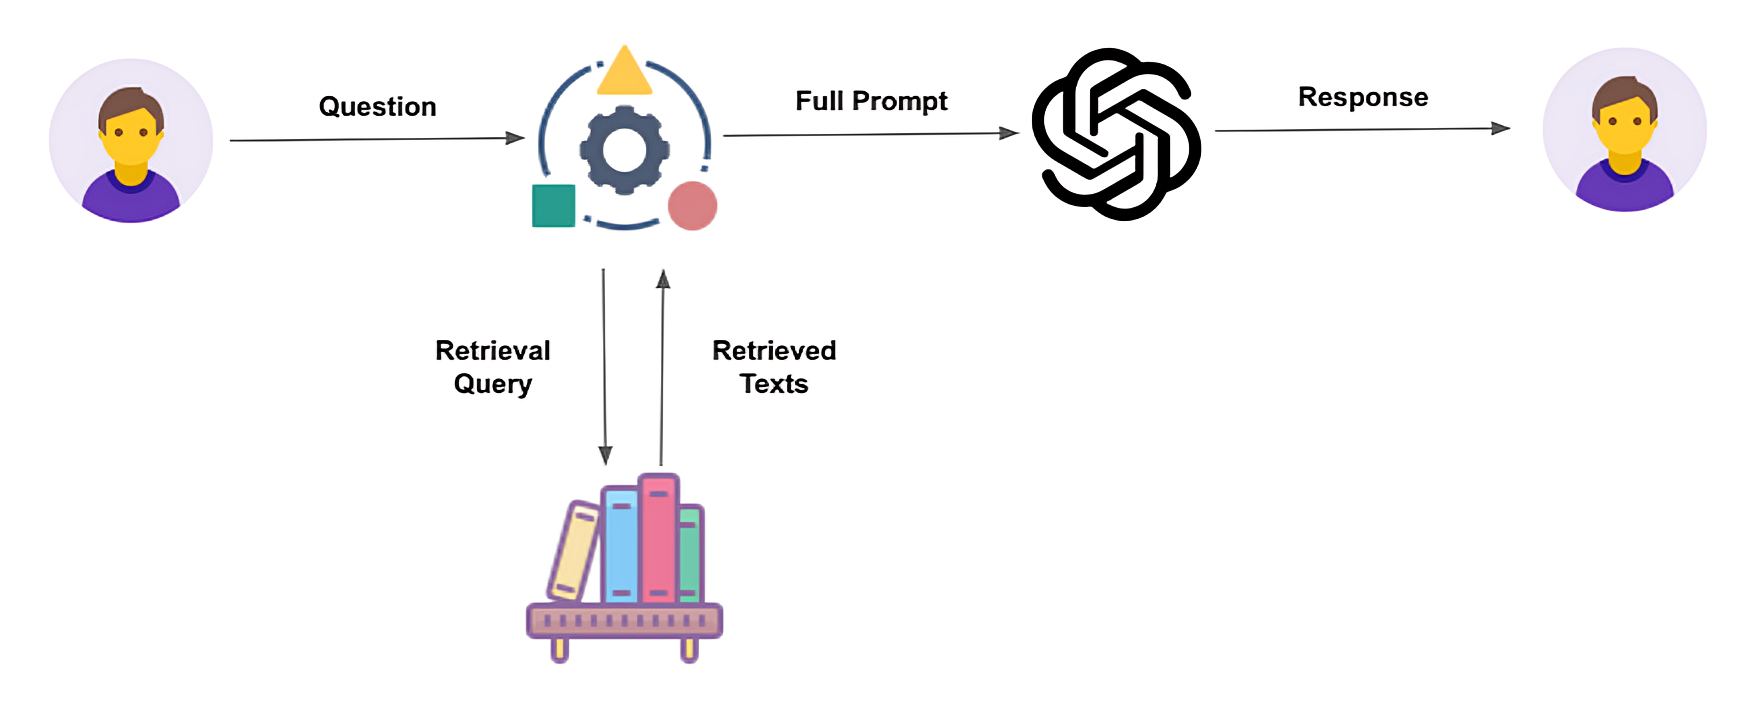

##**Objective**
The objective of this project is to develop a system for processing customer queries about menu items in a restaurant setting. Using a Retrieval-Augmented Generation (RAG) approach, the system aims to accurately understand and respond to customer inquiries in real-time, thereby automating the overall customer experience. The project focuses on demonstrating the capabilities of RAG through a demo menu.

##**Project Overview**
The project is structured into three parts, each essential to achieving a seamless flow from receiving a customer's query to generating an appropriate response. The three parts are:

**1. Vector Database Setup:** This part involves the creation of a in-memory vector database to store menu items as vector representations. This database serves as the foundation for efficiently matching customer queries with relevant menu items based on semantic similarity. The process includes converting the menu items into vectors using NLP techniques and storing these vectors in a way that supports fast retrieval.

**2. Query Processing:** At this stage, the system processes customer queries to understand their intent and the specifics of their requests. This involves interpreting the query, extracting relevant information, and converting this information into a vector form that can be compared against the menu stored in the vector database. The goal is to find the menu items that best match the customer's query.

**3. Response Generation:** Once a match is found, this part of the system is responsible for generating a response to the customer's query. The response generation process uses the information retrieved from the database to construct a clear and concise message that addresses the customer's request, providing details about the matched menu items, such as name, price, and any other relevant information.

##**1. Vector Database Setup**
This step involves creating a structured database from the available menu JSON file, which includes categorizing items by type (e.g., chicken, burgers, drinks) and preparing them for vectorization.

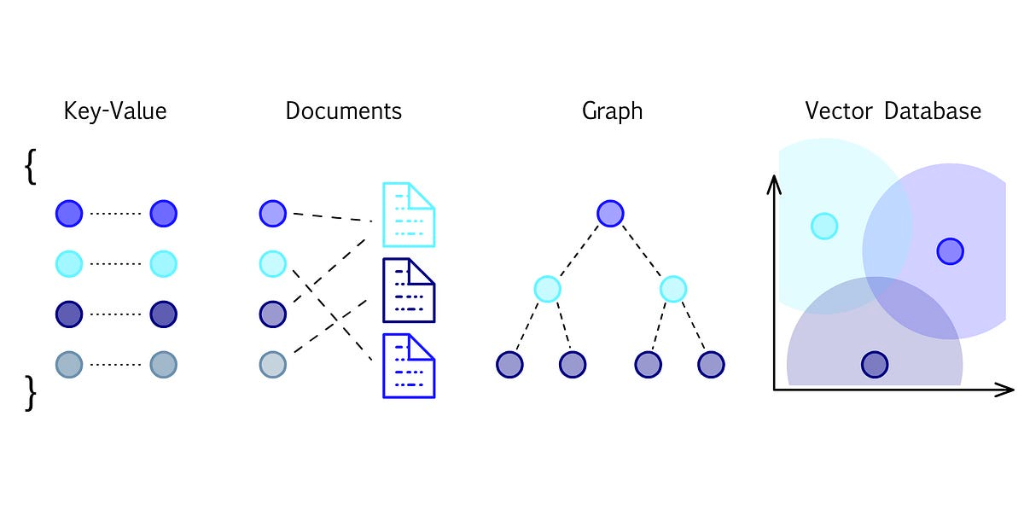

###**1.1 Create an In-Memory Vector Database**

In [ ]:
!pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=550742 sha256=ff564d986ddd2be7bf84256a0bf8839efd6a3d62838b4dfb09ac13e2b3efcf92
  Stored in directory: /root/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
Successfully built annoy


In [ ]:
# Importing the essential libraries
from annoy import AnnoyIndex
import json
import spacy
from gensim.models import Word2Vec
import numpy as np
import time
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from io import StringIO
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
dimension = 100  # Vector dimensionality
n_trees = 10  # More trees, better precision, slower build
index = AnnoyIndex(dimension, 'angular')  # Using angular distance

In [ ]:
# Example: Add item with ID 0
index.add_item(0, [0.5]*dimension)

In [ ]:
# Build the index
index.build(n_trees)

True

In [ ]:
# Saving the index to disk for reuse
index.save('menu_index.ann')
print("Index is built and saved.")

Index is built and saved.


In [ ]:
# Load the index back
index.load('menu_index.ann')
print("Index is loaded.")

Index is loaded.


###**1.2 Convert menu.json to Vectors**

In [ ]:
# Provide the file path of the menu.json file
file_path = 'menu.json'

In [ ]:
# Open the file and load its content into a variable
with open(file_path, 'r') as file:
    menu_data = json.load(file)

In [ ]:
# Now, 'menu_data' contains the content of 'menu.json'
print(menu_data)  # This will print the content of the menu data

{'Location': {'name': 'KFC'}, 'Chicken': {'C1': ['Original Recipe', 3.5, {'nutritionalInfo': {'kcal': 400, 'fat': 22, 'protein': 28, 'itemId': 4, 'allergens': ['wheat', 'soy']}, 'available': False}], 'C2': ['Popcorn Chicken', 4, {'nutritionalInfo': {'kcal': 350, 'fat': 20, 'protein': 25, 'itemId': 6, 'allergens': ['wheat', 'soy']}, 'available': False}], 'C4': ['Hot Wings', 3, {'nutritionalInfo': {'kcal': 270, 'fat': 18, 'protein': 19, 'itemId': 5, 'allergens': ['wheat']}, 'available': False}], 'C5': ['Snackbox', 15, {'nutritionalInfo': {'kcal': 150, 'fat': 100, 'protein': 10, 'itemId': 69, 'allergens': ['']}, 'available': False}], 'C6': ['Crispy Tenders', 15, {'nutritionalInfo': {'kcal': 150, 'fat': 100, 'protein': 10, 'itemId': 70, 'allergens': ['']}, 'available': False}], 'C7': ['Original Piece', 15, {'nutritionalInfo': {'kcal': 150, 'fat': 100, 'protein': 10, 'itemId': 76, 'allergens': ['']}, 'available': False}], 'C8': ['Tender Chicken', 15, {'nutritionalInfo': {'kcal': 150, 'fat':

####**1.2.1 Restructuring Chicken Menu**

In [ ]:
restructured_chicken = []

In [ ]:
for item_id, details in menu_data["Chicken"].items():
    item_name, price, item_details = details
    nutritional_info = item_details['nutritionalInfo']
    available = item_details['available']
    allergens = nutritional_info.get('allergens', [])

    restructured_item = {
        "id": item_id,
        "name": item_name,
        "type": "Chicken",
        "price": price,
        "nutritionalInfo": nutritional_info,
        "available": available,
        "allergens": allergens
    }

    restructured_chicken.append(restructured_item)

In [ ]:
print(restructured_chicken)

[{'id': 'C1', 'name': 'Original Recipe', 'type': 'Chicken', 'price': 3.5, 'nutritionalInfo': {'kcal': 400, 'fat': 22, 'protein': 28, 'itemId': 4, 'allergens': ['wheat', 'soy']}, 'available': False, 'allergens': ['wheat', 'soy']}, {'id': 'C2', 'name': 'Popcorn Chicken', 'type': 'Chicken', 'price': 4, 'nutritionalInfo': {'kcal': 350, 'fat': 20, 'protein': 25, 'itemId': 6, 'allergens': ['wheat', 'soy']}, 'available': False, 'allergens': ['wheat', 'soy']}, {'id': 'C4', 'name': 'Hot Wings', 'type': 'Chicken', 'price': 3, 'nutritionalInfo': {'kcal': 270, 'fat': 18, 'protein': 19, 'itemId': 5, 'allergens': ['wheat']}, 'available': False, 'allergens': ['wheat']}, {'id': 'C5', 'name': 'Snackbox', 'type': 'Chicken', 'price': 15, 'nutritionalInfo': {'kcal': 150, 'fat': 100, 'protein': 10, 'itemId': 69, 'allergens': ['']}, 'available': False, 'allergens': ['']}, {'id': 'C6', 'name': 'Crispy Tenders', 'type': 'Chicken', 'price': 15, 'nutritionalInfo': {'kcal': 150, 'fat': 100, 'protein': 10, 'itemI

In [ ]:
# Function to concatenate item information into a text string
def process_text(chicken_items):
    processed_items = []
    for item in chicken_items:
        # Combine name, type, and allergens into a string
        name_type = f"{item['name']} {item['type']}"
        allergens = " ".join(item['allergens']) if item['allergens'] else "No allergens"
        processed_text = f"{name_type} {allergens}"

        processed_items.append({
            'id': item['id'],
            'text': processed_text,
            'nutritionalInfo': item['nutritionalInfo'],
            'available': item['available']
        })
    return processed_items

# Process the chicken items to get text representation
processed_chicken_items = process_text(restructured_chicken)

In [ ]:
# Creating an Empty list which we will be extending to include the entire restructured menu
menu = []

In [ ]:
# Printing the menu list
menu

[]

In [ ]:
# Example output
for item in processed_chicken_items:
    print(item)

{'id': 'C1', 'text': 'Original Recipe Chicken wheat soy', 'nutritionalInfo': {'kcal': 400, 'fat': 22, 'protein': 28, 'itemId': 4, 'allergens': ['wheat', 'soy']}, 'available': False}
{'id': 'C2', 'text': 'Popcorn Chicken Chicken wheat soy', 'nutritionalInfo': {'kcal': 350, 'fat': 20, 'protein': 25, 'itemId': 6, 'allergens': ['wheat', 'soy']}, 'available': False}
{'id': 'C4', 'text': 'Hot Wings Chicken wheat', 'nutritionalInfo': {'kcal': 270, 'fat': 18, 'protein': 19, 'itemId': 5, 'allergens': ['wheat']}, 'available': False}
{'id': 'C5', 'text': 'Snackbox Chicken ', 'nutritionalInfo': {'kcal': 150, 'fat': 100, 'protein': 10, 'itemId': 69, 'allergens': ['']}, 'available': False}
{'id': 'C6', 'text': 'Crispy Tenders Chicken ', 'nutritionalInfo': {'kcal': 150, 'fat': 100, 'protein': 10, 'itemId': 70, 'allergens': ['']}, 'available': False}
{'id': 'C7', 'text': 'Original Piece Chicken ', 'nutritionalInfo': {'kcal': 150, 'fat': 100, 'protein': 10, 'itemId': 76, 'allergens': ['']}, 'available'

In [ ]:
# Function to concatenate item information into a text string
def process_text(chicken_items):
    processed_items = []
    for item in chicken_items:
        # Combine name, type, and allergens into a string
        name_type = f"{item['name']} {item['type']}"
        allergens = " ".join(item['allergens']) if item['allergens'] else "No allergens"
        processed_text = f"{name_type} {allergens}"

        processed_items.append({
            'id': item['id'],
            'text': processed_text
        })
    return processed_items

# Process the chicken items to get text representation
processed_chicken_items = process_text(restructured_chicken)

# Example output
for item in processed_chicken_items:
    print(item)

{'id': 'C1', 'text': 'Original Recipe Chicken wheat soy'}
{'id': 'C2', 'text': 'Popcorn Chicken Chicken wheat soy'}
{'id': 'C4', 'text': 'Hot Wings Chicken wheat'}
{'id': 'C5', 'text': 'Snackbox Chicken '}
{'id': 'C6', 'text': 'Crispy Tenders Chicken '}
{'id': 'C7', 'text': 'Original Piece Chicken '}
{'id': 'C8', 'text': 'Tender Chicken Chicken '}


In [ ]:
# Extending the menu list to include the Restructured Chicken Menu
menu.extend(processed_chicken_items)

In [ ]:
# Printing the menu list to view the updated items in the list
menu

[{'id': 'C1', 'text': 'Original Recipe Chicken wheat soy'},
 {'id': 'C2', 'text': 'Popcorn Chicken Chicken wheat soy'},
 {'id': 'C4', 'text': 'Hot Wings Chicken wheat'},
 {'id': 'C5', 'text': 'Snackbox Chicken '},
 {'id': 'C6', 'text': 'Crispy Tenders Chicken '},
 {'id': 'C7', 'text': 'Original Piece Chicken '},
 {'id': 'C8', 'text': 'Tender Chicken Chicken '}]

####**1.2.2 Restructuring Drinks Menu**

In [ ]:
# Initialize a list to hold restructured drink items
restructured_drinks = []

# Iterate over the "Drinks" category in your original JSON structure
for drink_id, details in menu_data["Drinks"].items():
    drink_name = details[0]
    price = details[1]
    # Some drinks might not have 'nutritionalInfo', so we use .get() method to safely extract it
    nutritional_info = details[2].get('nutritionalInfo', {})
    available = details[2].get('available', False)

    # Create a new dictionary for each drink including all its details and a 'type' field
    restructured_drink = {
        "id": drink_id,
        "name": drink_name,
        "type": "Drink",
        "price": price,
        "nutritionalInfo": nutritional_info,
        "available": available
    }

    # Append this dictionary to the list
    restructured_drinks.append(restructured_drink)

In [ ]:
print(restructured_drinks)

[{'id': 'D1', 'name': 'Iced Tea', 'type': 'Drink', 'price': 2.8, 'nutritionalInfo': {'kcal': 340, 'fat': 17, 'protein': 4, 'itemId': 12, 'allergens': ['wheat']}, 'available': False}, {'id': 'D2', 'name': 'Pepsi', 'type': 'Drink', 'price': 2.8, 'nutritionalInfo': {'kcal': 170, 'fat': 10, 'protein': 2, 'itemId': 9, 'allergens': ['dairy']}, 'available': False}, {'id': 'D3', 'name': '7Up', 'type': 'Drink', 'price': 2.8, 'nutritionalInfo': {'kcal': 340, 'fat': 17, 'protein': 4, 'itemId': 10, 'allergens': ['wheat']}, 'available': False}, {'id': 'D4', 'name': 'Fanta', 'type': 'Drink', 'price': 2.8, 'nutritionalInfo': {'kcal': 170, 'fat': 10, 'protein': 2, 'itemId': 11, 'allergens': ['dairy']}, 'available': False}, {'id': 'D5', 'name': 'Sourcy', 'type': 'Drink', 'price': 15, 'nutritionalInfo': {}, 'available': False}, {'id': 'D6', 'name': 'Tropicana Apple', 'type': 'Drink', 'price': 15, 'nutritionalInfo': {}, 'available': False}, {'id': 'D7', 'name': 'Guava', 'type': 'Drink', 'price': 15, 'nut

In [ ]:
def process_drink_text(drink_items):
    processed_items = []
    for item in drink_items:
        # Combine name and type
        name_type = f"{item['name']} {item['type']}"

        # Handle allergens, defaulting to "No allergens" if none are present
        allergens = " ".join(item['nutritionalInfo'].get('allergens', ['No allergens'])) if 'nutritionalInfo' in item and 'allergens' in item['nutritionalInfo'] else "No allergens"

        processed_text = f"{name_type} {allergens}"

        processed_items.append({
            'id': item['id'],
            'text': processed_text
        })
    return processed_items

# Process the drinks items to get text representation
processed_drinks_items = process_drink_text(restructured_drinks)

In [ ]:
# Example output
for item in processed_drinks_items:
    print(item)

{'id': 'D1', 'text': 'Iced Tea Drink wheat'}
{'id': 'D2', 'text': 'Pepsi Drink dairy'}
{'id': 'D3', 'text': '7Up Drink wheat'}
{'id': 'D4', 'text': 'Fanta Drink dairy'}
{'id': 'D5', 'text': 'Sourcy Drink No allergens'}
{'id': 'D6', 'text': 'Tropicana Apple Drink No allergens'}
{'id': 'D7', 'text': 'Guava Drink No allergens'}
{'id': 'D8', 'text': 'Tea Drink No allergens'}
{'id': 'D9', 'text': 'Latte Drink No allergens'}
{'id': 'D10', 'text': 'Espresso Drink No allergens'}
{'id': 'D11', 'text': 'Coffee Drink No allergens'}
{'id': 'D12', 'text': 'Sisi Drink No allergens'}
{'id': 'D13', 'text': 'Fernandes Drink No allergens'}
{'id': 'D14', 'text': 'Lipton Drink No allergens'}


In [ ]:
# Extending the menu list to include the Restructured Drinks Menu
menu.extend(processed_drinks_items)

In [ ]:
# Printing the menu list to view the updated items in the list
menu

[{'id': 'C1', 'text': 'Original Recipe Chicken wheat soy'},
 {'id': 'C2', 'text': 'Popcorn Chicken Chicken wheat soy'},
 {'id': 'C4', 'text': 'Hot Wings Chicken wheat'},
 {'id': 'C5', 'text': 'Snackbox Chicken '},
 {'id': 'C6', 'text': 'Crispy Tenders Chicken '},
 {'id': 'C7', 'text': 'Original Piece Chicken '},
 {'id': 'C8', 'text': 'Tender Chicken Chicken '},
 {'id': 'D1', 'text': 'Iced Tea Drink wheat'},
 {'id': 'D2', 'text': 'Pepsi Drink dairy'},
 {'id': 'D3', 'text': '7Up Drink wheat'},
 {'id': 'D4', 'text': 'Fanta Drink dairy'},
 {'id': 'D5', 'text': 'Sourcy Drink No allergens'},
 {'id': 'D6', 'text': 'Tropicana Apple Drink No allergens'},
 {'id': 'D7', 'text': 'Guava Drink No allergens'},
 {'id': 'D8', 'text': 'Tea Drink No allergens'},
 {'id': 'D9', 'text': 'Latte Drink No allergens'},
 {'id': 'D10', 'text': 'Espresso Drink No allergens'},
 {'id': 'D11', 'text': 'Coffee Drink No allergens'},
 {'id': 'D12', 'text': 'Sisi Drink No allergens'},
 {'id': 'D13', 'text': 'Fernandes Dr

####**1.2.3 Restructuring Burgers Menu**

In [ ]:
# New structure for items including nutritional information handling
restructured_burgers = []

# Iterate over Burgers
for burger_key, burger_value in menu_data["Burgers"].items():
    # Initialize a dictionary for each burger
    burger_dict = {
        "id": burger_key,
        "name": burger_value[0],
        "price": burger_value[1],
        "type": "Burger",
        "available": burger_value[2].get("available", True)  # Default to True if not specified
    }

    # Check if nutritionalInfo exists, then include it
    if "nutritionalInfo" in burger_value[2]:
        burger_dict["nutritionalInfo"] = burger_value[2]["nutritionalInfo"]

    # Append the burger dictionary to the items list
    restructured_burgers.append(burger_dict)

In [ ]:
print(restructured_burgers)

[{'id': 'B1', 'name': 'Crunch Burger', 'price': 15, 'type': 'Burger', 'available': False, 'nutritionalInfo': {'kcal': 150, 'fat': 100, 'protein': 10, 'itemId': 77, 'allergens': ['']}}, {'id': 'B2', 'name': 'Original Fillet Breaded', 'price': 15, 'type': 'Burger', 'available': False, 'nutritionalInfo': {'kcal': 150, 'fat': 100, 'protein': 10, 'itemId': 84, 'allergens': ['']}}, {'id': 'B3', 'name': 'Original Fillet', 'price': 15, 'type': 'Burger', 'available': False}, {'id': 'B4', 'name': 'Filet Burger', 'price': 4.7, 'type': 'Burger', 'available': False, 'nutritionalInfo': {'kcal': 400, 'fat': 20, 'protein': 27, 'itemId': 3, 'allergens': ['wheat', 'soy']}}, {'id': 'B5', 'name': 'Zinger Burger', 'price': 4.5, 'type': 'Burger', 'available': False, 'nutritionalInfo': {'kcal': 451, 'fat': 25, 'protein': 28, 'itemId': 1, 'allergens': ['wheat', 'soy']}}, {'id': 'B6', 'name': 'Tower Burger', 'price': 5.2, 'type': 'Burger', 'available': False, 'nutritionalInfo': {'kcal': 500, 'fat': 30, 'protei

In [ ]:
def process_burger_text(burger_items):
    processed_items = []
    for item in burger_items:
        # Combine name and type
        name_type = f"{item['name']} {item['type']}"

        # Check for allergens in nutritionalInfo, defaulting to "No allergens" if none are present
        allergens = " ".join(item['nutritionalInfo'].get('allergens', ['No allergens'])) if 'nutritionalInfo' in item and 'allergens' in item['nutritionalInfo'] else "No allergens"

        processed_text = f"{name_type} {allergens}"

        processed_items.append({
            'id': item['id'],
            'text': processed_text
        })
    return processed_items

# Assuming restructured_burgers is your list of burgers with the new structure
processed_burgers_items = process_burger_text(restructured_burgers)

In [ ]:
# Example output
for item in processed_burgers_items:
    print(item)

{'id': 'B1', 'text': 'Crunch Burger Burger '}
{'id': 'B2', 'text': 'Original Fillet Breaded Burger '}
{'id': 'B3', 'text': 'Original Fillet Burger No allergens'}
{'id': 'B4', 'text': 'Filet Burger Burger wheat soy'}
{'id': 'B5', 'text': 'Zinger Burger Burger wheat soy'}
{'id': 'B6', 'text': 'Tower Burger Burger wheat soy'}
{'id': 'B7', 'text': 'Veggie Burger Burger whey soy'}
{'id': 'B8', 'text': 'Fire Zinger Stacker Burger '}
{'id': 'B9', 'text': 'Fire Zinger Burger '}
{'id': 'B10', 'text': 'Colonel Stacker Burger '}
{'id': 'B11', 'text': 'Colonel Burger Burger '}
{'id': 'B12', 'text': 'Veggie Tender Burger '}
{'id': 'B13', 'text': 'Filet Bites Burger '}
{'id': 'B14', 'text': 'Original Burger Burger '}
{'id': 'B15', 'text': 'Zinger Burger Burger '}
{'id': 'B16', 'text': 'Cheeseburger Burger '}
{'id': 'B17', 'text': 'Zinger Filet Burger '}


In [ ]:
# Extending the menu list to include the Restructured Burgers Menu
menu.extend(processed_burgers_items)

In [ ]:
# Printing the menu list to view the updated items in the list
menu

[{'id': 'C1', 'text': 'Original Recipe Chicken wheat soy'},
 {'id': 'C2', 'text': 'Popcorn Chicken Chicken wheat soy'},
 {'id': 'C4', 'text': 'Hot Wings Chicken wheat'},
 {'id': 'C5', 'text': 'Snackbox Chicken '},
 {'id': 'C6', 'text': 'Crispy Tenders Chicken '},
 {'id': 'C7', 'text': 'Original Piece Chicken '},
 {'id': 'C8', 'text': 'Tender Chicken Chicken '},
 {'id': 'D1', 'text': 'Iced Tea Drink wheat'},
 {'id': 'D2', 'text': 'Pepsi Drink dairy'},
 {'id': 'D3', 'text': '7Up Drink wheat'},
 {'id': 'D4', 'text': 'Fanta Drink dairy'},
 {'id': 'D5', 'text': 'Sourcy Drink No allergens'},
 {'id': 'D6', 'text': 'Tropicana Apple Drink No allergens'},
 {'id': 'D7', 'text': 'Guava Drink No allergens'},
 {'id': 'D8', 'text': 'Tea Drink No allergens'},
 {'id': 'D9', 'text': 'Latte Drink No allergens'},
 {'id': 'D10', 'text': 'Espresso Drink No allergens'},
 {'id': 'D11', 'text': 'Coffee Drink No allergens'},
 {'id': 'D12', 'text': 'Sisi Drink No allergens'},
 {'id': 'D13', 'text': 'Fernandes Dr

####**1.2.4 Restructuring Sauces Menu**

In [ ]:
# New structure for sauces
restructured_sauces = []

# Iterate over the "Sauces" section
for sauce_id, details in menu_data["Sauces"].items():
    sauce_dict = {
        "id": sauce_id,
        "name": details[0],
        "price": details[1],
        "type": "Sauce",
        # Default availability to True if not specified
        "available": details[2].get("available", True)
    }
    # Add the structured sauce dictionary to the sauces list
    restructured_sauces.append(sauce_dict)

In [ ]:
print(restructured_sauces)

[{'id': 'S1', 'name': 'Apple Sauce', 'price': 15, 'type': 'Sauce', 'available': False}]


In [ ]:
def process_sauce_text(sauce_items):
    processed_items = []
    for item in sauce_items:
        # Since there's no nutritional info or allergens provided, just combine name and type
        name_type = f"{item['name']} {item['type']}"

        processed_text = name_type  # For sauces, we might not have allergens or other detailed info

        processed_items.append({
            'id': item['id'],
            'text': processed_text
        })
    return processed_items

# Process the sauces items to get text representation
processed_sauces_items = process_sauce_text(restructured_sauces)

In [ ]:
# Example output
for item in processed_sauces_items:
    print(item)

{'id': 'S1', 'text': 'Apple Sauce Sauce'}


In [ ]:
# Extending the menu list to include the Restructured Sauces Menu
menu.extend(processed_sauces_items)

In [ ]:
# Printing the menu list to view the updated items in the list
menu

[{'id': 'C1', 'text': 'Original Recipe Chicken wheat soy'},
 {'id': 'C2', 'text': 'Popcorn Chicken Chicken wheat soy'},
 {'id': 'C4', 'text': 'Hot Wings Chicken wheat'},
 {'id': 'C5', 'text': 'Snackbox Chicken '},
 {'id': 'C6', 'text': 'Crispy Tenders Chicken '},
 {'id': 'C7', 'text': 'Original Piece Chicken '},
 {'id': 'C8', 'text': 'Tender Chicken Chicken '},
 {'id': 'D1', 'text': 'Iced Tea Drink wheat'},
 {'id': 'D2', 'text': 'Pepsi Drink dairy'},
 {'id': 'D3', 'text': '7Up Drink wheat'},
 {'id': 'D4', 'text': 'Fanta Drink dairy'},
 {'id': 'D5', 'text': 'Sourcy Drink No allergens'},
 {'id': 'D6', 'text': 'Tropicana Apple Drink No allergens'},
 {'id': 'D7', 'text': 'Guava Drink No allergens'},
 {'id': 'D8', 'text': 'Tea Drink No allergens'},
 {'id': 'D9', 'text': 'Latte Drink No allergens'},
 {'id': 'D10', 'text': 'Espresso Drink No allergens'},
 {'id': 'D11', 'text': 'Coffee Drink No allergens'},
 {'id': 'D12', 'text': 'Sisi Drink No allergens'},
 {'id': 'D13', 'text': 'Fernandes Dr

####**1.2.5 Restructuring Side Dish Menu**

In [ ]:
# Initialize a list to hold restructured drink items
restructured_sd = []

# Iterate over the "Drinks" category in your original JSON structure
for sd_id, details in menu_data["Side dishes"].items():
    sd_name = details[0]
    price = details[1]
    # Some drinks might not have 'nutritionalInfo', so we use .get() method to safely extract it
    nutritional_info = details[2].get('nutritionalInfo', {})
    available = details[2].get('available', False)

    # Create a new dictionary for each drink including all its details and a 'type' field
    restructured_dict = {
        "id": sd_id,
        "name": sd_name,
        "type": "Side dish",
        "price": price,
        "nutritionalInfo": nutritional_info,
        "available": available
    }

    # Append this dictionary to the list
    restructured_sd.append(restructured_dict)

In [ ]:
restructured_sd

[{'id': 'SD1',
  'name': 'Coleslaw',
  'type': 'Side dish',
  'price': 1.7,
  'nutritionalInfo': {'kcal': 170,
   'fat': 10,
   'protein': 2,
   'itemId': 7,
   'allergens': ['dairy']},
  'available': False},
 {'id': 'SD2',
  'name': 'Fries',
  'type': 'Side dish',
  'price': 2.5,
  'nutritionalInfo': {'kcal': 340,
   'fat': 17,
   'protein': 4,
   'itemId': 8,
   'allergens': ['wheat']},
  'available': False},
 {'id': 'SD3',
  'name': 'Corn',
  'type': 'Side dish',
  'price': 15,
  'nutritionalInfo': {'kcal': 150,
   'fat': 100,
   'protein': 10,
   'itemId': 73,
   'allergens': ['']},
  'available': False}]

In [ ]:
def process_side_dish_text(side_dish_items):
    processed_items = []
    for item in side_dish_items:
        # Combine name and type
        name_type = f"{item['name']} {item['type']}"

        # Handle allergens, defaulting to "No allergens" if none are present
        allergens = " ".join(item['nutritionalInfo'].get('allergens', ['No allergens'])) if 'nutritionalInfo' in item and 'allergens' in item['nutritionalInfo'] and item['nutritionalInfo']['allergens'] else "No allergens"

        processed_text = f"{name_type} {allergens}"

        processed_items.append({
            'id': item['id'],
            'text': processed_text
        })
    return processed_items

# Process the side dishes items to get text representation
processed_side_dishes_items = process_side_dish_text(restructured_sd)

In [ ]:
# Example output
for item in processed_side_dishes_items:
    print(item)

{'id': 'SD1', 'text': 'Coleslaw Side dish dairy'}
{'id': 'SD2', 'text': 'Fries Side dish wheat'}
{'id': 'SD3', 'text': 'Corn Side dish '}


In [ ]:
# Extending the menu list to include the Restructured Side Dish Menu
menu.extend(processed_side_dishes_items)

In [ ]:
# Printing the menu list to view the updated items in the list
menu

[{'id': 'C1', 'text': 'Original Recipe Chicken wheat soy'},
 {'id': 'C2', 'text': 'Popcorn Chicken Chicken wheat soy'},
 {'id': 'C4', 'text': 'Hot Wings Chicken wheat'},
 {'id': 'C5', 'text': 'Snackbox Chicken '},
 {'id': 'C6', 'text': 'Crispy Tenders Chicken '},
 {'id': 'C7', 'text': 'Original Piece Chicken '},
 {'id': 'C8', 'text': 'Tender Chicken Chicken '},
 {'id': 'D1', 'text': 'Iced Tea Drink wheat'},
 {'id': 'D2', 'text': 'Pepsi Drink dairy'},
 {'id': 'D3', 'text': '7Up Drink wheat'},
 {'id': 'D4', 'text': 'Fanta Drink dairy'},
 {'id': 'D5', 'text': 'Sourcy Drink No allergens'},
 {'id': 'D6', 'text': 'Tropicana Apple Drink No allergens'},
 {'id': 'D7', 'text': 'Guava Drink No allergens'},
 {'id': 'D8', 'text': 'Tea Drink No allergens'},
 {'id': 'D9', 'text': 'Latte Drink No allergens'},
 {'id': 'D10', 'text': 'Espresso Drink No allergens'},
 {'id': 'D11', 'text': 'Coffee Drink No allergens'},
 {'id': 'D12', 'text': 'Sisi Drink No allergens'},
 {'id': 'D13', 'text': 'Fernandes Dr

####**1.2.6 Restructuring Desserts Menu**

In [ ]:
# Initialize a list to hold restructured drink items
restructured_dessert = []

# Iterate over the "Drinks" category in your original JSON structure
for dessert_id, details in menu_data["Desserts"].items():
    dessert_name = details[0]
    price = details[1]
    # Some drinks might not have 'nutritionalInfo', so we use .get() method to safely extract it
    nutritional_info = details[2].get('nutritionalInfo', {})
    available = details[2].get('available', False)

    # Create a new dictionary for each drink including all its details and a 'type' field
    restructured_dessert_dict = {
        "id": dessert_id,
        "name": dessert_name,
        "type": "Desserts",
        "price": price,
        "nutritionalInfo": nutritional_info,
        "available": available
    }

    # Append this dictionary to the list
    restructured_dessert.append(restructured_dessert_dict)

In [ ]:
restructured_dessert

[{'id': 'DE1',
  'name': 'Chocolate Sundae',
  'type': 'Desserts',
  'price': 2.5,
  'nutritionalInfo': {'kcal': 220,
   'fat': 9,
   'protein': 3,
   'itemId': 13,
   'allergens': ['dairy', 'soy']},
  'available': False},
 {'id': 'DE2',
  'name': 'Apple Pie',
  'type': 'Desserts',
  'price': 2.2,
  'nutritionalInfo': {'kcal': 250,
   'fat': 12,
   'protein': 2,
   'itemId': 14,
   'allergens': ['wheat', 'soy']},
  'available': False},
 {'id': 'DE3',
  'name': 'Ice Cream',
  'type': 'Desserts',
  'price': 15,
  'nutritionalInfo': {'kcal': 150,
   'fat': 100,
   'protein': 10,
   'itemId': 95,
   'allergens': ['']},
  'available': False}]

In [ ]:
def process_dessert_text(dessert_items):
    processed_items = []
    for item in dessert_items:
        # Combine name and type
        name_type = f"{item['name']} {item['type']}"

        # Handle allergens, defaulting to "No allergens" if none are present
        allergens = " ".join(item['nutritionalInfo'].get('allergens', ['No allergens'])) if 'nutritionalInfo' in item and 'allergens' in item['nutritionalInfo'] and item['nutritionalInfo']['allergens'] else "No allergens"

        processed_text = f"{name_type} {allergens}"

        processed_items.append({
            'id': item['id'],
            'text': processed_text
        })
    return processed_items

# Process the desserts items to get text representation
processed_desserts_items = process_dessert_text(restructured_dessert)

In [ ]:
# Example output
for item in processed_desserts_items:
    print(item)

{'id': 'DE1', 'text': 'Chocolate Sundae Desserts dairy soy'}
{'id': 'DE2', 'text': 'Apple Pie Desserts wheat soy'}
{'id': 'DE3', 'text': 'Ice Cream Desserts '}


In [ ]:
# Extending the menu list to include the Restructured Dessert Menu
menu.extend(processed_desserts_items)

In [ ]:
# Printing the menu list to view the updated items in the list
menu

[{'id': 'C1', 'text': 'Original Recipe Chicken wheat soy'},
 {'id': 'C2', 'text': 'Popcorn Chicken Chicken wheat soy'},
 {'id': 'C4', 'text': 'Hot Wings Chicken wheat'},
 {'id': 'C5', 'text': 'Snackbox Chicken '},
 {'id': 'C6', 'text': 'Crispy Tenders Chicken '},
 {'id': 'C7', 'text': 'Original Piece Chicken '},
 {'id': 'C8', 'text': 'Tender Chicken Chicken '},
 {'id': 'D1', 'text': 'Iced Tea Drink wheat'},
 {'id': 'D2', 'text': 'Pepsi Drink dairy'},
 {'id': 'D3', 'text': '7Up Drink wheat'},
 {'id': 'D4', 'text': 'Fanta Drink dairy'},
 {'id': 'D5', 'text': 'Sourcy Drink No allergens'},
 {'id': 'D6', 'text': 'Tropicana Apple Drink No allergens'},
 {'id': 'D7', 'text': 'Guava Drink No allergens'},
 {'id': 'D8', 'text': 'Tea Drink No allergens'},
 {'id': 'D9', 'text': 'Latte Drink No allergens'},
 {'id': 'D10', 'text': 'Espresso Drink No allergens'},
 {'id': 'D11', 'text': 'Coffee Drink No allergens'},
 {'id': 'D12', 'text': 'Sisi Drink No allergens'},
 {'id': 'D13', 'text': 'Fernandes Dr

####**1.2.7 Restructuring Vegetarian Menu**

In [ ]:
# Initialize a list to hold restructured drink items
restructured_vegetarian = []

# Iterate over the "Drinks" category in your original JSON structure
for vegetarian_id, details in menu_data["Vegetarian"].items():
    vegetarian_name = details[0]
    price = details[1]
    # Some drinks might not have 'nutritionalInfo', so we use .get() method to safely extract it
    nutritional_info = details[2].get('nutritionalInfo', {})
    available = details[2].get('available', False)

    # Create a new dictionary for each drink including all its details and a 'type' field
    restructured_vegetarian_dict = {
        "id": vegetarian_id,
        "name": vegetarian_name,
        "type": "Vegetarian",
        "price": price,
        "nutritionalInfo": nutritional_info,
        "available": available
    }

    # Append this dictionary to the list
    restructured_vegetarian.append(restructured_vegetarian_dict)

In [ ]:
restructured_vegetarian

[{'id': 'V1',
  'name': 'Veggie',
  'type': 'Vegetarian',
  'price': 15,
  'nutritionalInfo': {'kcal': 150,
   'fat': 100,
   'protein': 10,
   'itemId': 72,
   'allergens': ['']},
  'available': False},
 {'id': 'V2',
  'name': 'Veggie Tenders',
  'type': 'Vegetarian',
  'price': 15,
  'nutritionalInfo': {'kcal': 150,
   'fat': 100,
   'protein': 10,
   'itemId': 78,
   'allergens': ['']},
  'available': False}]

In [ ]:
def process_vegetarian_text(vegetarian_items):
    processed_items = []
    for item in vegetarian_items:
        # Combine name and type
        name_type = f"{item['name']} {item['type']}"

        # Handle allergens, defaulting to "No allergens" if none are present
        allergens = " ".join(item['nutritionalInfo'].get('allergens', ['No allergens'])) if 'nutritionalInfo' in item and 'allergens' in item['nutritionalInfo'] and item['nutritionalInfo']['allergens'] else "No allergens"

        processed_text = f"{name_type} {allergens}"

        processed_items.append({
            'id': item['id'],
            'text': processed_text
        })
    return processed_items

# Process the vegetarian items to get text representation
processed_vegetarian_items = process_vegetarian_text(restructured_vegetarian)

In [ ]:
# Example output
for item in processed_vegetarian_items:
    print(item)

{'id': 'V1', 'text': 'Veggie Vegetarian '}
{'id': 'V2', 'text': 'Veggie Tenders Vegetarian '}


In [ ]:
# Extending the menu list to include the Restructured Vegetarian Menu
menu.extend(processed_vegetarian_items)

In [ ]:
# Printing the menu list to view the updated items in the list
menu

[{'id': 'C1', 'text': 'Original Recipe Chicken wheat soy'},
 {'id': 'C2', 'text': 'Popcorn Chicken Chicken wheat soy'},
 {'id': 'C4', 'text': 'Hot Wings Chicken wheat'},
 {'id': 'C5', 'text': 'Snackbox Chicken '},
 {'id': 'C6', 'text': 'Crispy Tenders Chicken '},
 {'id': 'C7', 'text': 'Original Piece Chicken '},
 {'id': 'C8', 'text': 'Tender Chicken Chicken '},
 {'id': 'D1', 'text': 'Iced Tea Drink wheat'},
 {'id': 'D2', 'text': 'Pepsi Drink dairy'},
 {'id': 'D3', 'text': '7Up Drink wheat'},
 {'id': 'D4', 'text': 'Fanta Drink dairy'},
 {'id': 'D5', 'text': 'Sourcy Drink No allergens'},
 {'id': 'D6', 'text': 'Tropicana Apple Drink No allergens'},
 {'id': 'D7', 'text': 'Guava Drink No allergens'},
 {'id': 'D8', 'text': 'Tea Drink No allergens'},
 {'id': 'D9', 'text': 'Latte Drink No allergens'},
 {'id': 'D10', 'text': 'Espresso Drink No allergens'},
 {'id': 'D11', 'text': 'Coffee Drink No allergens'},
 {'id': 'D12', 'text': 'Sisi Drink No allergens'},
 {'id': 'D13', 'text': 'Fernandes Dr

####**1.2.8 Building a Mapping between Menu ID and Item ID**

In [ ]:
# Initialize variables
id_to_number = {}
number_to_id = {}
current_number = 1  # Start numbering from 1

In [ ]:
# Iterate over each item in the dataset and assign numbers to IDs
for item in menu:
    item_id = item['id']
    # Check if the ID already has a number assigned
    if item_id not in id_to_number:
        # Assign a new number to the ID
        id_to_number[item_id] = current_number
        number_to_id[current_number] = item_id
        current_number += 1  # Increment the number for the next ID

In [ ]:
# Update IDs in the menu to their corresponding numbers
for item in menu:
    item['id'] = id_to_number[item['id']]

In [ ]:
# Example output
print("ID to Number Mapping:", id_to_number)
print("Number to ID Mapping:", number_to_id)
print("Updated Menu:", menu)  # Print first 5 items for brevity

ID to Number Mapping: {'C1': 1, 'C2': 2, 'C4': 3, 'C5': 4, 'C6': 5, 'C7': 6, 'C8': 7, 'D1': 8, 'D2': 9, 'D3': 10, 'D4': 11, 'D5': 12, 'D6': 13, 'D7': 14, 'D8': 15, 'D9': 16, 'D10': 17, 'D11': 18, 'D12': 19, 'D13': 20, 'D14': 21, 'B1': 22, 'B2': 23, 'B3': 24, 'B4': 25, 'B5': 26, 'B6': 27, 'B7': 28, 'B8': 29, 'B9': 30, 'B10': 31, 'B11': 32, 'B12': 33, 'B13': 34, 'B14': 35, 'B15': 36, 'B16': 37, 'B17': 38, 'S1': 39, 'SD1': 40, 'SD2': 41, 'SD3': 42, 'DE1': 43, 'DE2': 44, 'DE3': 45, 'V1': 46, 'V2': 47}
Number to ID Mapping: {1: 'C1', 2: 'C2', 3: 'C4', 4: 'C5', 5: 'C6', 6: 'C7', 7: 'C8', 8: 'D1', 9: 'D2', 10: 'D3', 11: 'D4', 12: 'D5', 13: 'D6', 14: 'D7', 15: 'D8', 16: 'D9', 17: 'D10', 18: 'D11', 19: 'D12', 20: 'D13', 21: 'D14', 22: 'B1', 23: 'B2', 24: 'B3', 25: 'B4', 26: 'B5', 27: 'B6', 28: 'B7', 29: 'B8', 30: 'B9', 31: 'B10', 32: 'B11', 33: 'B12', 34: 'B13', 35: 'B14', 36: 'B15', 37: 'B16', 38: 'B17', 39: 'S1', 40: 'SD1', 41: 'SD2', 42: 'SD3', 43: 'DE1', 44: 'DE2', 45: 'DE3', 46: 'V1', 47: 

In [ ]:
id_to_number

{'C1': 1,
 'C2': 2,
 'C4': 3,
 'C5': 4,
 'C6': 5,
 'C7': 6,
 'C8': 7,
 'D1': 8,
 'D2': 9,
 'D3': 10,
 'D4': 11,
 'D5': 12,
 'D6': 13,
 'D7': 14,
 'D8': 15,
 'D9': 16,
 'D10': 17,
 'D11': 18,
 'D12': 19,
 'D13': 20,
 'D14': 21,
 'B1': 22,
 'B2': 23,
 'B3': 24,
 'B4': 25,
 'B5': 26,
 'B6': 27,
 'B7': 28,
 'B8': 29,
 'B9': 30,
 'B10': 31,
 'B11': 32,
 'B12': 33,
 'B13': 34,
 'B14': 35,
 'B15': 36,
 'B16': 37,
 'B17': 38,
 'S1': 39,
 'SD1': 40,
 'SD2': 41,
 'SD3': 42,
 'DE1': 43,
 'DE2': 44,
 'DE3': 45,
 'V1': 46,
 'V2': 47}

In [ ]:
number_to_id

{1: 'C1',
 2: 'C2',
 3: 'C4',
 4: 'C5',
 5: 'C6',
 6: 'C7',
 7: 'C8',
 8: 'D1',
 9: 'D2',
 10: 'D3',
 11: 'D4',
 12: 'D5',
 13: 'D6',
 14: 'D7',
 15: 'D8',
 16: 'D9',
 17: 'D10',
 18: 'D11',
 19: 'D12',
 20: 'D13',
 21: 'D14',
 22: 'B1',
 23: 'B2',
 24: 'B3',
 25: 'B4',
 26: 'B5',
 27: 'B6',
 28: 'B7',
 29: 'B8',
 30: 'B9',
 31: 'B10',
 32: 'B11',
 33: 'B12',
 34: 'B13',
 35: 'B14',
 36: 'B15',
 37: 'B16',
 38: 'B17',
 39: 'S1',
 40: 'SD1',
 41: 'SD2',
 42: 'SD3',
 43: 'DE1',
 44: 'DE2',
 45: 'DE3',
 46: 'V1',
 47: 'V2'}

In [ ]:
# Printing the menu list to view the updated items in the list
menu

[{'id': 1, 'text': 'Original Recipe Chicken wheat soy'},
 {'id': 2, 'text': 'Popcorn Chicken Chicken wheat soy'},
 {'id': 3, 'text': 'Hot Wings Chicken wheat'},
 {'id': 4, 'text': 'Snackbox Chicken '},
 {'id': 5, 'text': 'Crispy Tenders Chicken '},
 {'id': 6, 'text': 'Original Piece Chicken '},
 {'id': 7, 'text': 'Tender Chicken Chicken '},
 {'id': 8, 'text': 'Iced Tea Drink wheat'},
 {'id': 9, 'text': 'Pepsi Drink dairy'},
 {'id': 10, 'text': '7Up Drink wheat'},
 {'id': 11, 'text': 'Fanta Drink dairy'},
 {'id': 12, 'text': 'Sourcy Drink No allergens'},
 {'id': 13, 'text': 'Tropicana Apple Drink No allergens'},
 {'id': 14, 'text': 'Guava Drink No allergens'},
 {'id': 15, 'text': 'Tea Drink No allergens'},
 {'id': 16, 'text': 'Latte Drink No allergens'},
 {'id': 17, 'text': 'Espresso Drink No allergens'},
 {'id': 18, 'text': 'Coffee Drink No allergens'},
 {'id': 19, 'text': 'Sisi Drink No allergens'},
 {'id': 20, 'text': 'Fernandes Drink No allergens'},
 {'id': 21, 'text': 'Lipton Drink

###**1.3 Converting Text to Vector**

In [ ]:
# Simulate a file-like object for gensim LineSentence
text_data = "\n".join([item['text'] for item in menu])
file_like_text_data = StringIO(text_data)

# Training the Word2Vec model
model = Word2Vec(LineSentence(file_like_text_data), vector_size=100, window=5, min_count=1, workers=4)

# Converting text to vectors
vector_data = []
for item in menu:
    words = item['text'].split()
    vector = np.mean([model.wv[word] for word in words if word in model.wv], axis=0)
    vector_data.append({'id': item['id'], 'vector': vector})

In [ ]:
# Now vector_data contains the vectors for each item
for item in vector_data:  # Example: showing vectors for the first two items
    print(item['id'], item['vector'])

1 [-3.25281918e-03  2.82706134e-03 -2.29607616e-03  1.04250805e-03
  2.10814225e-03  2.40962650e-03  5.01381699e-03  1.13727560e-03
 -4.54264414e-03 -1.03510730e-03 -4.15090472e-05 -1.97409347e-04
 -2.66622379e-03  3.24113280e-05  4.78036411e-04 -3.95116117e-03
 -7.44853343e-04  2.51436280e-03 -2.20700656e-03 -3.02607333e-03
 -2.89270142e-03 -2.00189324e-03  8.38873442e-03  7.84748816e-04
 -1.27235113e-03 -1.20839139e-03 -1.67982711e-03 -5.08103240e-03
 -1.10022747e-03 -2.47623248e-04  3.53928958e-03 -2.29270686e-03
 -3.36895639e-04 -1.31855835e-03 -7.75138382e-04  1.00925600e-03
 -4.16336494e-04  2.07320834e-03  1.78468635e-03 -3.11240437e-03
  3.08261905e-03 -2.72324495e-03  3.27398993e-05  5.04736781e-05
  1.92426727e-03 -2.08097699e-04 -2.73819407e-03  1.44508330e-03
  1.15713476e-04 -3.04457289e-03  3.13958945e-03 -3.67095391e-03
  2.44806265e-03 -1.15789799e-03 -4.75536287e-03 -2.82676890e-03
  9.56328411e-04 -3.72383930e-03 -3.56241828e-03 -5.02549112e-03
  1.69708789e-03 -2.347

###**1.4 Save the Vector to in-memory Vector Database**

In [ ]:
# Assuming each vector is 100-dimensional
dimension = 100
index = AnnoyIndex(dimension, 'angular')  # Initialize Annoy index

# Insert vectors into the index, assuming vector_data is a list of dictionaries as shown in your output
for item in vector_data:
    item_id = item['id']  # This should already be an integer
    vector = item['vector']
    index.add_item(item_id, vector)  # Directly use item_id without conversion

# Build the index
index.build(10)  # 10 trees

# Save the index to disk (optional but recommended for persistence)
index.save('menu_index.ann')

True

In [ ]:
# Assuming 'vector_data' list's 'id' values have been converted to integers as per the mapping
first_item_id = vector_data[0]['id']  # This is already an integer now
first_vector = index.get_item_vector(first_item_id)

print(f"Vector for ID {first_item_id}: {first_vector}")

Vector for ID 1: [-0.0032528191804885864, 0.002827061340212822, -0.0022960761561989784, 0.0010425080545246601, 0.0021081422455608845, 0.0024096264969557524, 0.005013816989958286, 0.001137275598011911, -0.004542644135653973, -0.0010351072996854782, -4.150904715061188e-05, -0.00019740934658329934, -0.002666223794221878, 3.241132799303159e-05, 0.00047803641064092517, -0.003951161168515682, -0.0007448533433489501, 0.0025143628008663654, -0.002207006560638547, -0.003026073332875967, -0.002892701420933008, -0.0020018932409584522, 0.008388734422624111, 0.0007847488159313798, -0.0012723511317744851, -0.0012083913898095489, -0.0016798271099105477, -0.005081032402813435, -0.0011002274695783854, -0.00024762324756011367, 0.003539289580658078, -0.0022927068639546633, -0.00033689563861116767, -0.0013185583520680666, -0.0007751383818686008, 0.0010092559969052672, -0.0004163364937994629, 0.002073208335787058, 0.00178468634840101, -0.0031124043744057417, 0.003082619048655033, -0.0027232449501752853, 3.

##**2. Query Processing**
This part focuses on converting user queries into vector representations that can be compared with the vector database of menu items. It involves processing the query, transforming it into a vector, and finding the closest matching menu items based on vector similarity.

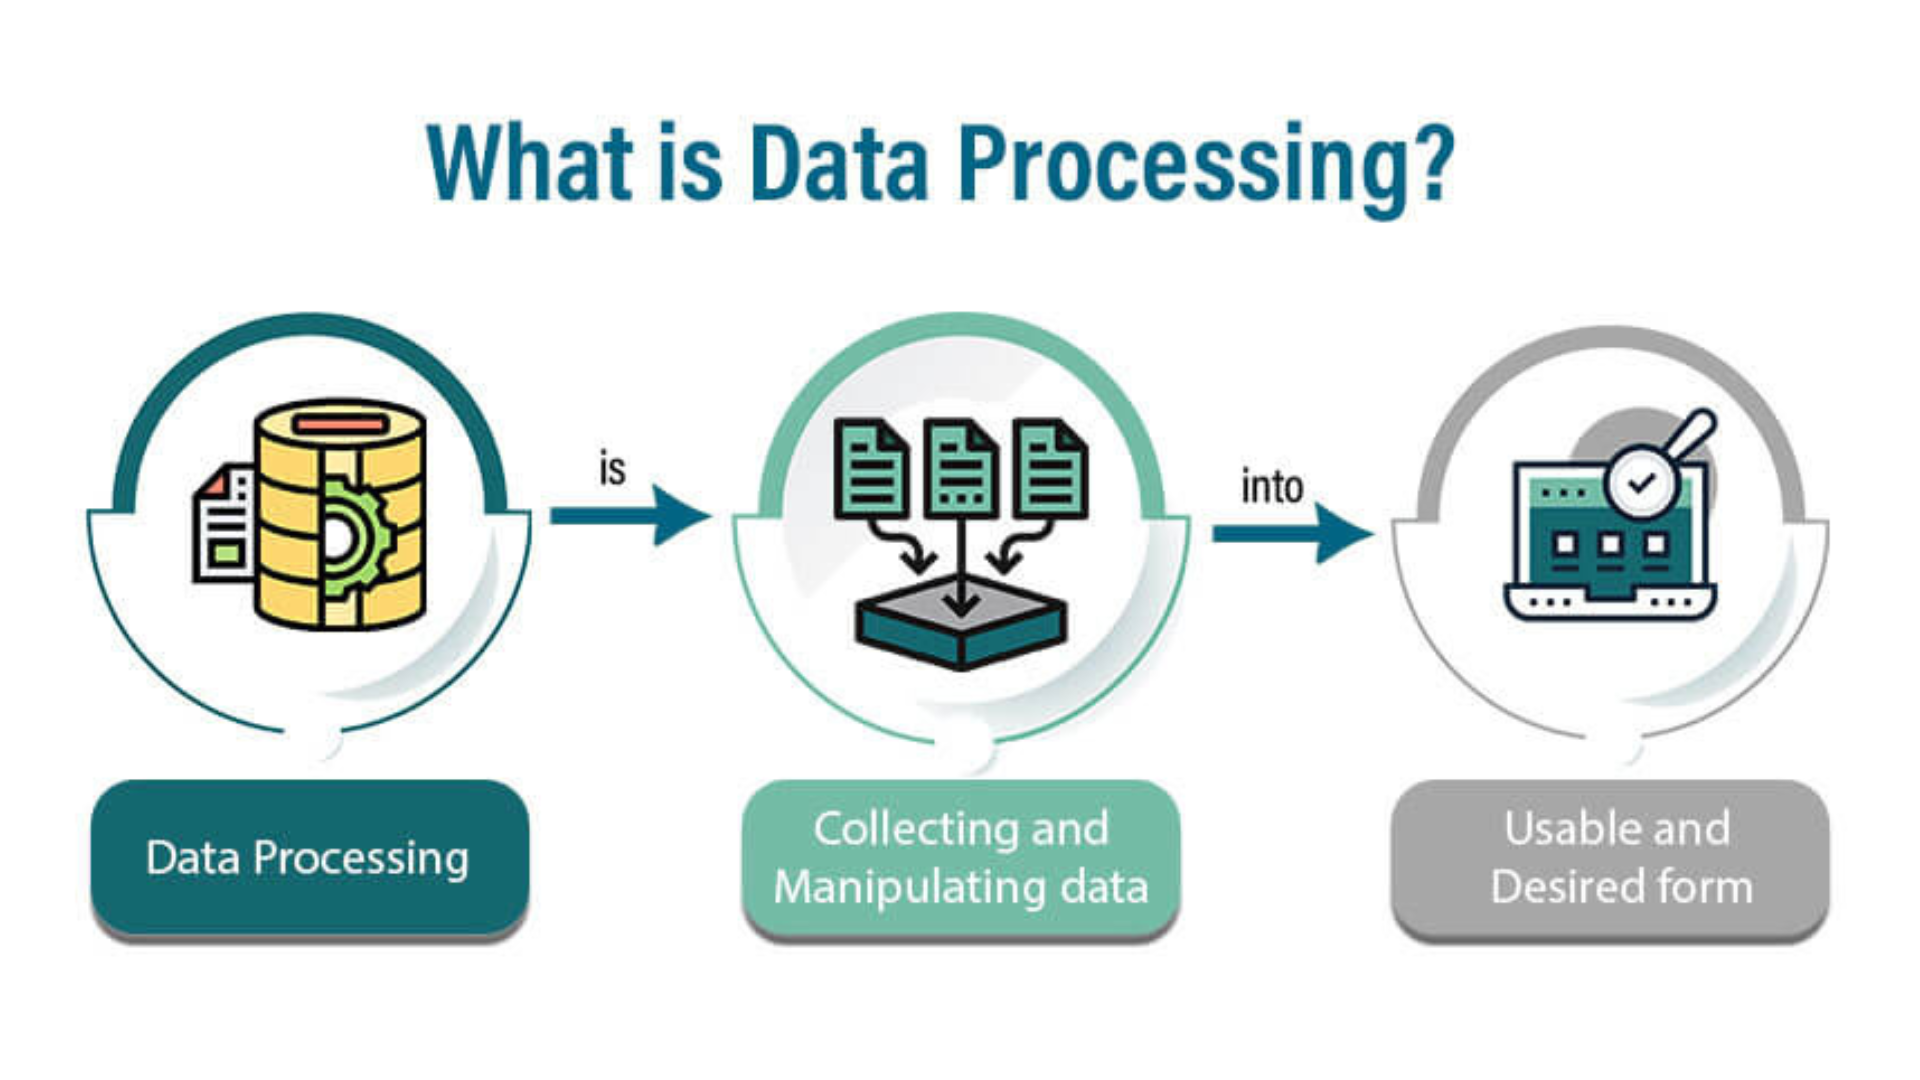

###**2.1 Query Interpretation**

In [ ]:
# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

In [ ]:
def process_query(query):
    # Process the query with spaCy
    doc = nlp(query)

    # Extract relevant parts of the query
    items = [token.lemma_ for token in doc if token.pos_ in ['NOUN', 'PROPN']]
    attributes = [token.lemma_ for token in doc if token.pos_ == 'ADJ']

    # Construct a representation similar to menu item entries
    query_representation = ' '.join(items + attributes)

    return query_representation

In [ ]:
# Example Query
query = "Can I get a Popcorn Chicken?"
query_representation = process_query(query)

###**2.2 Vector Representation**

In [ ]:
# Function to convert query representation to vector using the Word2Vec model
def query_to_vector(query_representation, model):
    words = query_representation.split()
    # Ensure all words are in the model's vocabulary
    vector = np.mean([model.wv[word] for word in words if word in model.wv], axis=0)
    return vector

In [ ]:
# Example Usage
query = "Can I get a Popcorn Chicken?"
processed_query = process_query(query)  # Assuming process_query is your function from the previous step
query_vector_representation = query_to_vector(processed_query, model)

print(f"Query Vector: {query_vector_representation}")

Query Vector: [-5.5756341e-03  4.8513520e-03  5.9191498e-04 -3.2128801e-03
 -5.3326674e-03 -5.6749610e-03  2.9364205e-03  3.3211254e-03
 -8.1683323e-03 -5.4169064e-03 -3.6768867e-03 -3.6924602e-03
 -1.6570394e-03 -3.7544717e-03  8.0306968e-04 -7.4143917e-03
 -6.0070911e-03 -4.7570304e-04  2.2160627e-03  1.8899818e-03
 -2.0597198e-03 -3.9860662e-03  8.1897993e-03  3.5407790e-04
 -7.4437032e-03  2.4310648e-03  3.1520252e-04 -9.4807195e-03
 -8.0950791e-04  6.2471563e-03  1.4422196e-03 -1.9221699e-03
 -2.2089628e-03 -2.0642639e-03  6.2090985e-04 -1.5436672e-05
  1.1795440e-03  6.9666114e-03  3.2990177e-03 -4.5669074e-03
  8.3010513e-03  3.6228215e-05 -2.2582244e-05 -1.1258679e-03
 -4.9522249e-03 -3.3558195e-03  2.2570509e-03  4.8797764e-04
  4.5359251e-03 -5.6966762e-03 -2.6817657e-03 -6.8443930e-03
  6.9361283e-03  4.2357412e-04 -4.7370605e-04 -3.7125684e-03
  6.7202682e-03 -2.1893312e-03 -3.4669428e-03  9.0197148e-04
  6.7489063e-03 -1.9959240e-04  6.9918744e-03 -8.7826769e-04
  3.375822

###**2.3 Vector Matching**

In [ ]:
# Assuming dimension is the dimensionality of your vectors
dimension = 100
index = AnnoyIndex(dimension, 'angular')

# Assuming you've already built and saved your index
index.load('menu_index.ann')  # Load the saved index

def find_similar_items(query_vector, n=1):
    """
    Find `n` most similar items in the vector database for the given query vector.

    Parameters:
    - query_vector: The vector representation of the user's query.
    - n: The number of similar items to retrieve.

    Returns:
    A list of tuples containing the index of the similar items and their similarity scores.
    """
    similar_items = index.get_nns_by_vector(query_vector, n, include_distances = True)
    return similar_items

In [ ]:
# Example usage
query_vector = query_vector_representation # Your query vector here
similar_items = find_similar_items(query_vector_representation, n = 5)  # Adjust `n` as needed

print(f"Similar Items: {similar_items}")

Similar Items: ([2, 7, 5, 4, 3], [0.552626371383667, 0.8443808555603027, 0.9677223563194275, 0.96779465675354, 0.9702332019805908])


In [ ]:
# Assuming `vector_data` is your list of dictionaries with 'id' and 'vector' from the in-memory database
# And `query_vector` is the vector representation of your query

def find_most_similar(vector, vector_data, top_n=1):
    # Convert vector_data to a list of vectors for comparison
    vectors = [item['vector'] for item in vector_data]
    # Calculate cosine similarity between the query vector and all vectors in the database
    similarities = cosine_similarity([vector], vectors)[0]
    # Get the top N indices of the most similar vectors
    top_indices = np.argsort(similarities)[-top_n:][::-1]
    # Retrieve IDs and similarities for the most similar items
    similar_items = [(vector_data[i]['id'], similarities[i]) for i in top_indices]
    return similar_items

# Example usage
top_similar_items = find_most_similar(query_vector_representation, vector_data, top_n=5)
print(f"Top Similar Items: {top_similar_items}")

Top Similar Items: [(2, 0.8473019), (7, 0.64351046), (5, 0.53175664), (4, 0.53168666), (3, 0.5293237)]


In [ ]:
top_similar_items

[(2, 0.8473019),
 (7, 0.64351046),
 (5, 0.53175664),
 (4, 0.53168666),
 (3, 0.5293237)]

In [ ]:
similarity_index = top_similar_items[0][0]

In [ ]:
similarity_index

2

###**2.4 Retrieving Matched Items**

In [ ]:
# Function to retrieve menu item details using vector ID
def retrieve_matched_items(vector_id, menu_data, mapping):
    # Translate vector ID to menu ID
    menu_id = mapping[vector_id]

    # Initialize result variable
    matched_item_details = {}

    # Iterate through menu categories and items
    for category, items in menu_data.items():
        if menu_id in items:
            matched_item_details = items[menu_id]
            break

    return matched_item_details

In [ ]:
# Example usage
# vector_id = 36  # Example vector ID
vector_id = similarity_index

mapping = number_to_id

matched_item_details = retrieve_matched_items(vector_id, menu_data, mapping)

print(f"Matched Item Details: {matched_item_details}")

Matched Item Details: ['Popcorn Chicken', 4, {'nutritionalInfo': {'kcal': 350, 'fat': 20, 'protein': 25, 'itemId': 6, 'allergens': ['wheat', 'soy']}, 'available': False}]


##**3. Response Generation**
Based on the matched items, this part generates a user-friendly response that includes the matched item's name, price, and potentially other details like nutritional information or allergens.

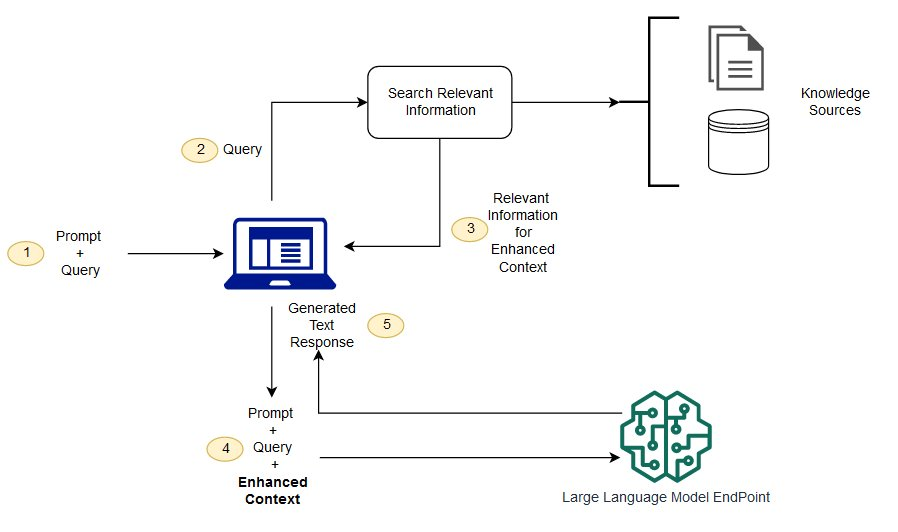

In [ ]:
def generate_response(matched_item):
    # Extracting item details from the matched item
    item_name, price, item_info = matched_item
    response = f"You have ordered {item_name}, priced at ${price}."
    return response

# Input example
# matched_item = ["Popcorn Chicken", 4, {'nutritionalInfo': {'kcal': 350, 'fat': 20, 'protein': 25, 'itemId': 6, 'allergens': ['wheat', 'soy']}, 'available': False}]
matched_item = matched_item_details

In [ ]:
# Generating the response
response = generate_response(matched_item)
print(response)

You have ordered Popcorn Chicken, priced at $4.


#**Time for Testing**

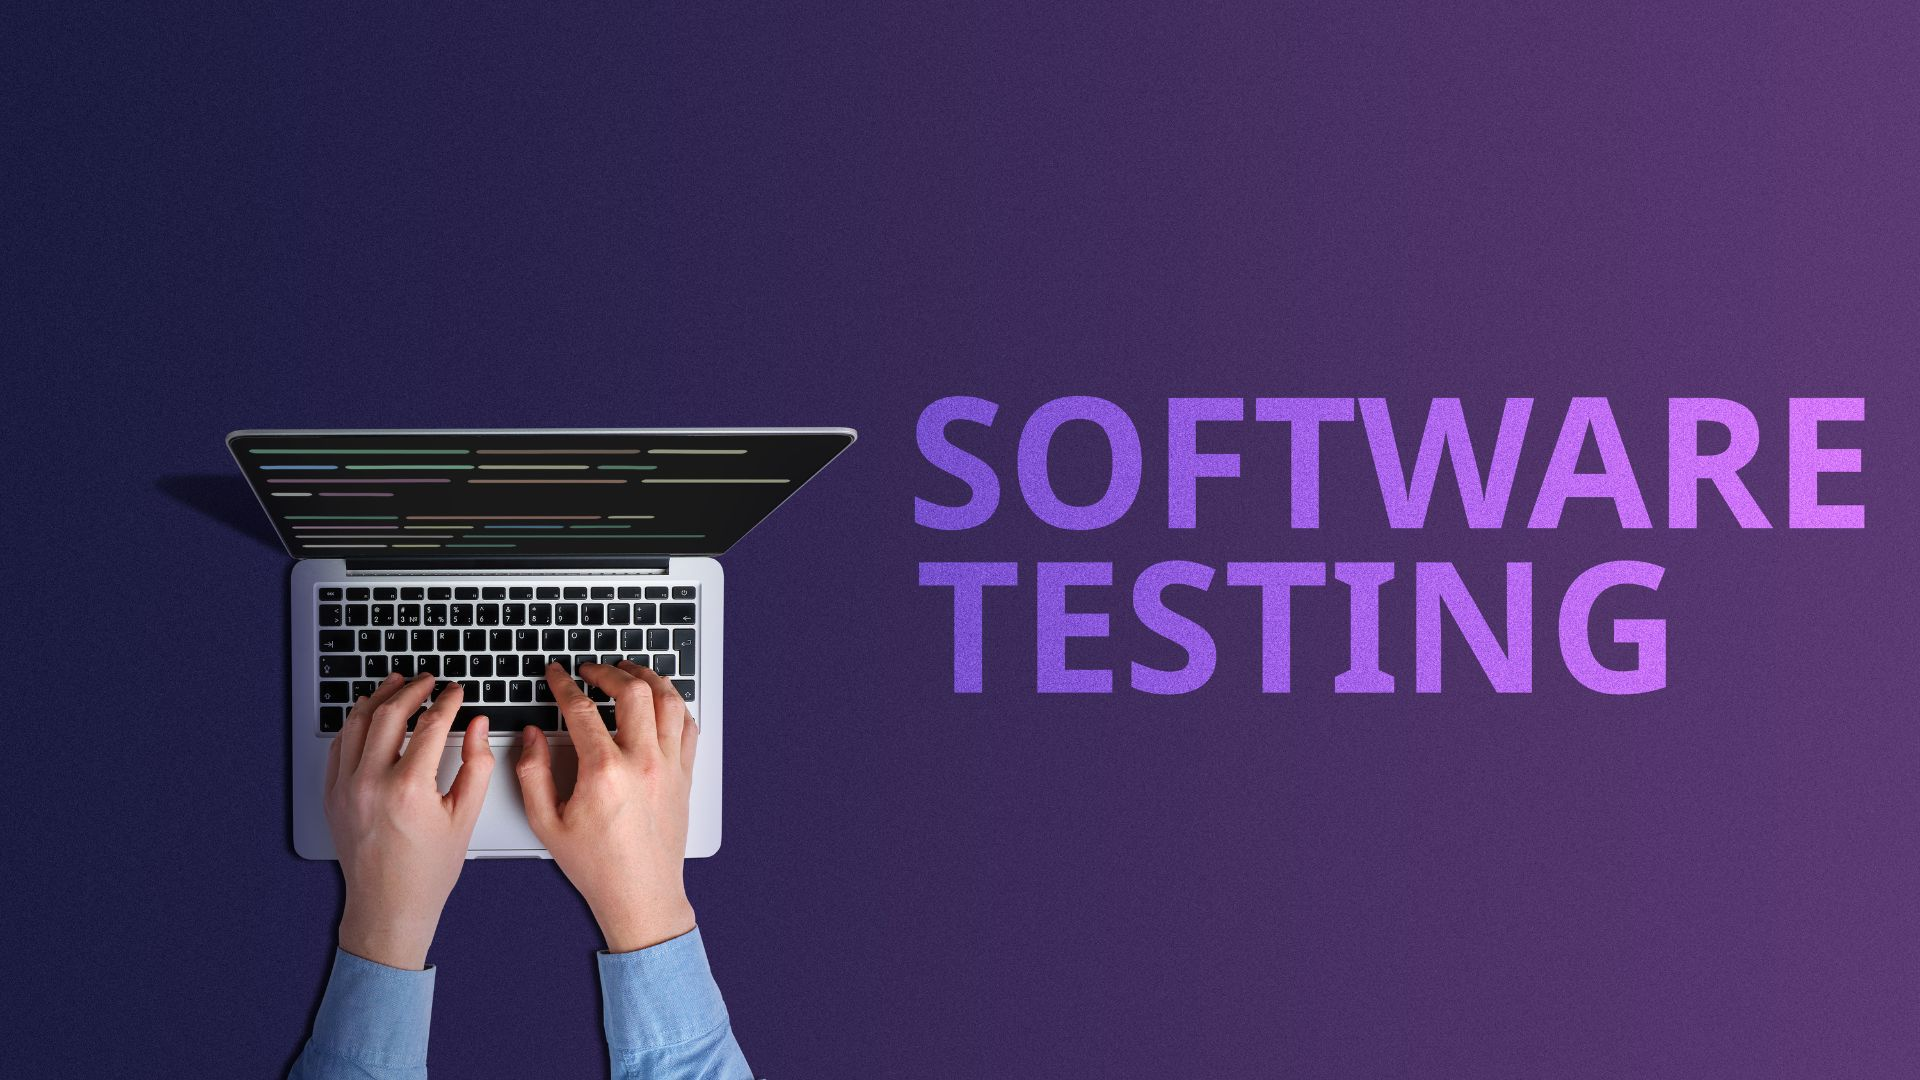

In [ ]:
# Start the timer
start_time = time.time()

# query = "Can I get a Popcorn Chicken?"
query = "Can you please order a Pepsi for me?"

# RAG based Processing
processed_query = process_query(query)  # Assuming process_query is your function from the previous step
query_vector_representation = query_to_vector(processed_query, model)
query_vector = query_vector_representation # Your query vector here
similar_items = find_similar_items(query_vector_representation, n = 3)  # Adjust `n` as needed
top_similar_items = find_most_similar(query_vector_representation, vector_data, top_n=3)
similarity_index = top_similar_items[0][0]
matched_item_details = retrieve_matched_items(similarity_index, menu_data, mapping)
response = generate_response(matched_item_details)

# End the timer
end_time = time.time()

# Calculate the duration in milliseconds
duration_ms = (end_time - start_time) * 1000

# Print the response and the time taken
print(response)
print(f"Response generated in {duration_ms:.2f} milliseconds.")

You have ordered Pepsi, priced at $2.8.
Response generated in 16.51 milliseconds.


#**The End**

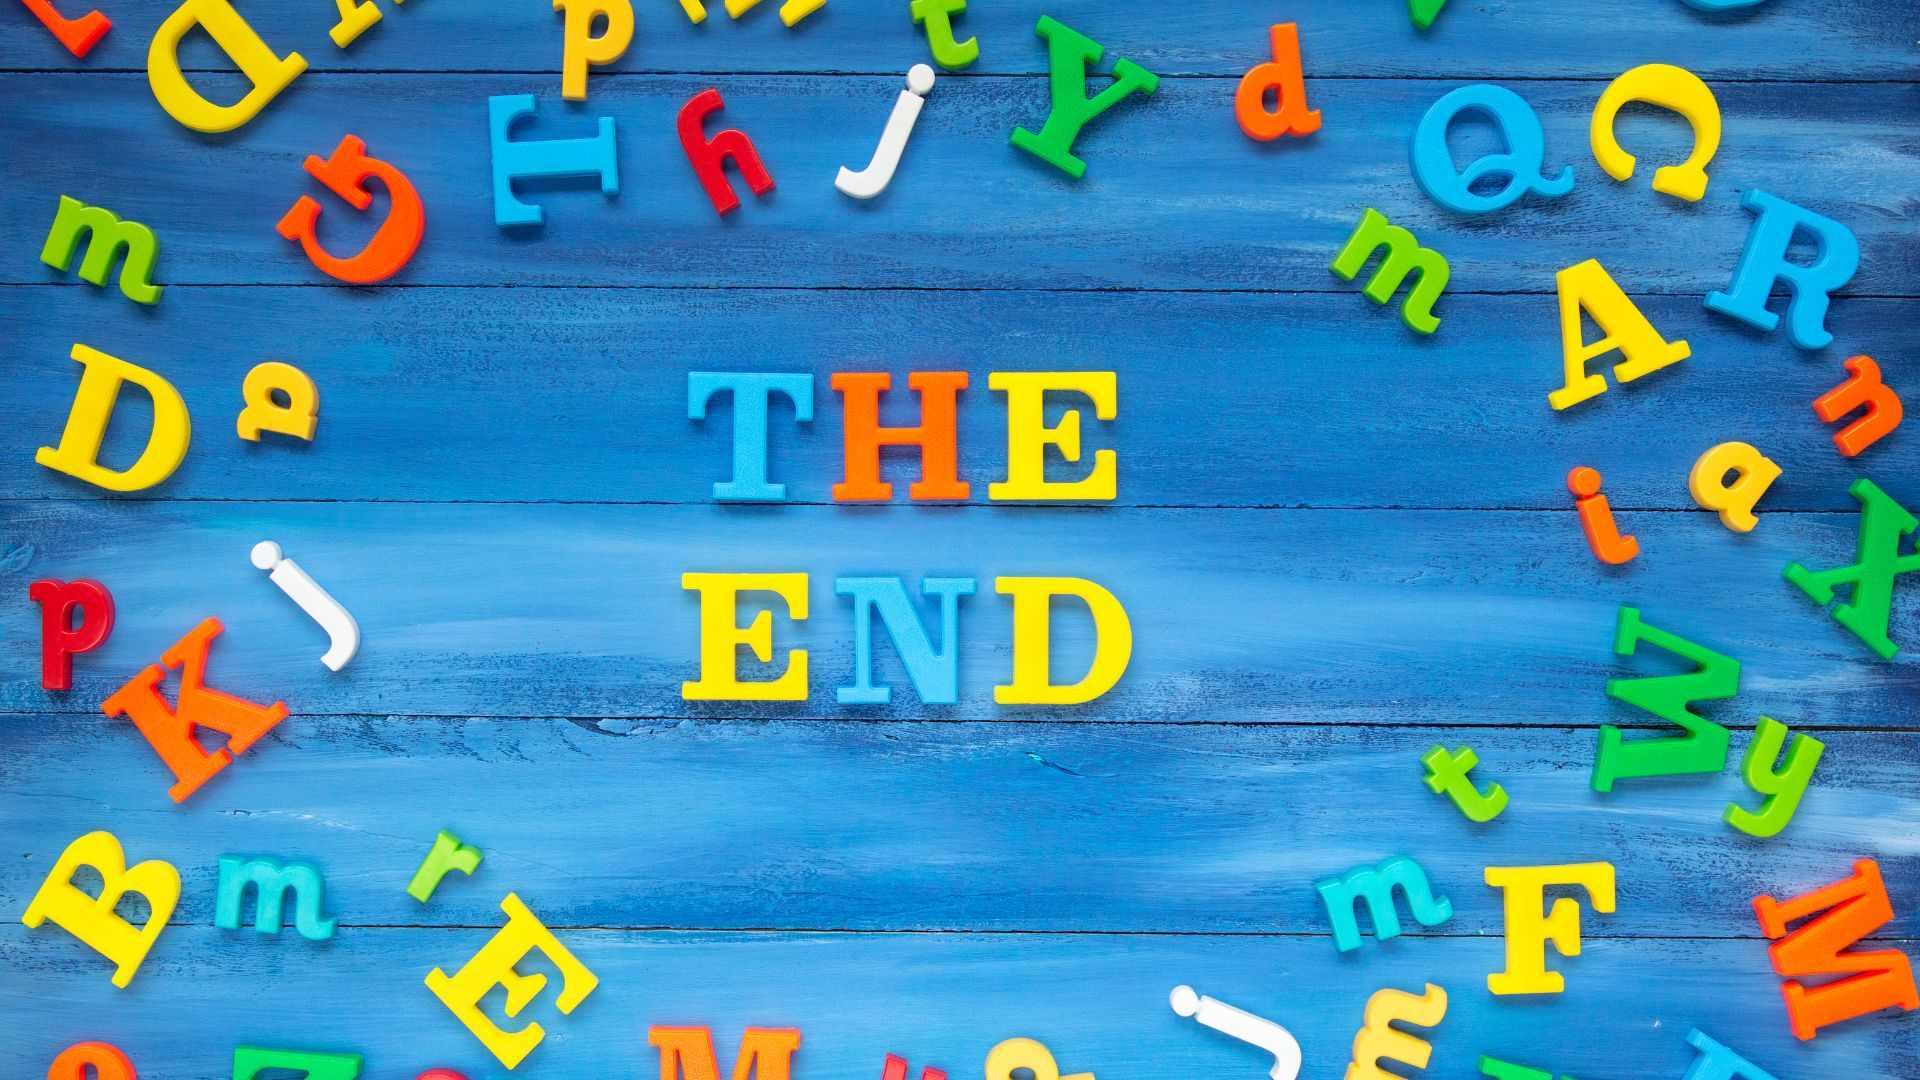